# Quién es quién en los precios 

Creando la sesión de spark

In [ ]:
from pyspark.sql import SparkSession
import pandas as pd

# Crear una sesión de Spark
spark = SparkSession.builder \
    .appName("Proyecto Parcial Arquitectura") \
    .getOrCreate()

Cargando los datos

In [ ]:
df3 = spark.read.option("delimiter", "|").option("header", True).csv("combined_with_names_fixed.csv")

df3.printSchema()

1. Guardar el CSV como parquet en S3, particionalo por catalogo

df3.write.partitionBy("catalogo").parquet("parquets/df_por_catalogo")

2. Carga el parquet en Spark

In [ ]:
df_parquet_byCat = spark.read.parquet("parquets/df_por_catalogo")

¿Cuántos catálogos diferentes tenemos? (por año)

In [ ]:
from pyspark.sql.functions import year, col, countDistinct

df_parquet = df_parquet.withColumn("Year", year(col("fecharegistro").cast("date")))
df_parquet = df_parquet.withColumn("Year", year("fecharegistro"))

# Count unique catalogo by Year
unique_counts = df_parquet.groupBy("Year").agg(countDistinct("catalogo").alias("UniqueCatalogo"))

# Show the results
unique_counts.show()

Y obtenemos:

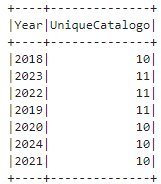

¿Cuáles son los 20 catálogos con más observaciones? Guarda la salida de este query en tu bucket de S3, lo necesitaremos más adelante.

Para esta pregunta usamos el top 5 pero dejamos la posibilidad de cambiar el parámetro para obtener los n catálogos con más observaciones.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, col, row_number
from pyspark.sql.window import Window

# Realizar la agrupación por 'catalogo' y 'Year', y calcular el conteo
catalogos_populares = df_parquet.groupBy("catalogo", "Year").agg(count("*").alias("Conteo"))

# Definir una ventana particionada por año y ordenada por el conteo descendente
windowSpec = Window.partitionBy("Year").orderBy(col("Conteo").desc())

# Aplicar row_number sobre cada partición de la ventana para obtener los rankings
catalogos_populares = catalogos_populares.withColumn("row_num", row_number().over(windowSpec))

# Filtrar para obtener los top N catálogos por año
top_n = 5  # Define cuántos top catálogos quieres obtener
top_catalogos_populares = catalogos_populares.filter(col("row_num") <= top_n).drop("row_num")

# Mostrar los resultados finales
top_catalogos_populares.show()


¿Tenemos datos de todos los estados del país? De no ser así, ¿cuáles faltan?

In [ ]:
from pyspark.sql.functions import col

# Extraer los estados distintos
df_estados = df_parquet.select("estado").distinct()

# Contar registros por estado
df_estados_presentes = df_parquet.select("estado", "Year").distinct()

# Extraer todos los años distintos presentes en df_parquet
df_anos = df_parquet.select("Year").distinct()

# Crear todas las combinaciones posibles de estados y años
df_combinaciones = df_estados.crossJoin(df_anos)

# Realizar un left anti join para encontrar las combinaciones que no están en los datos presentes
estados_faltantes = df_combinaciones.join(df_estados_presentes, ["estado", "Year"], "left_anti")

# Mostrar los estados faltantes por año
estados_faltantes.show()


¿Cuántas observaciones tenemos por estado?

In [ ]:
df_conteo_estado_anio = df_parquet.groupBy("Year", "estado").agg(count("*").alias("Conteo"))
df_conteo_estado_anio.show()

Para cada año, de cada estado obten: el número de catalogos diferentes por año, ¿ha aumentado el número de catálogos con el tiempo?

In [ ]:
df_catalogos_anio = df_parquet.groupBy("Year", "catalogo").agg(count("*").alias("Conteo"))

### Para el catálogo de "frutas y legumbres procesadas"

¿Cuańtas marcas diferentes tiene tu categoría? Para esta pregunta se toma la columna de "producto" como marca, ya que al ser frutas, carecen de marca. De modo que las preguntas que hagan referencia a marcas, se refieren a frutas o legumbres.

In [ ]:
df_marcas_distintas= df_parquet.filter(df_parquet["catalogo"]=="frutas y legumbres procesadas").select("producto").distinct()
df_marcas_distintas.show()

¿Cuál es la marca con mayor precio? ¿En qué estado?

¿Cuál es la marca con menor precio en CDMX? (en aquel entonces Distrito Federal)

¿Cuál es la marca con mayores observaciones?

¿Cuáles son el top 5 de marcas con mayor precio en cada estado? ¿Son diferentes?

¿Cuáles son el top 5 de marcas con menor precio en CDMX? (en aquel entonces Distrito Federal)

¿Cuáles son el top 5 de marcas con mayores observaciones? ¿Se parecen a las de nivel por estado?

¿Ha dejado de existir alguna marca durante los años que tienes? ¿Cuál? ¿Cuándo desapareció?

Genera una gráfica de serie de tiempo por estado para la marca con mayor precio -en todos los años-, donde el eje equis es el año y el eje ye es el precio máximo.